In [1]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
import wandb

We always check that we are running on a GPU

In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


We provide you with a class that can load the *hotdog/not hotdog* dataset you should use from /dtu/datasets1/02514/

In [3]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='/dtu/datasets1/02514/hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

Below is the simple way of converting the images to something that can be fed through a network.
Feel free to use something other than $128\times128$ images.

In [4]:
size = 128
train_transform = transforms.Compose([transforms.Resize((size, size)),                                    
                                    transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])

batch_size = 64
trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

Let's look at some images from our data 

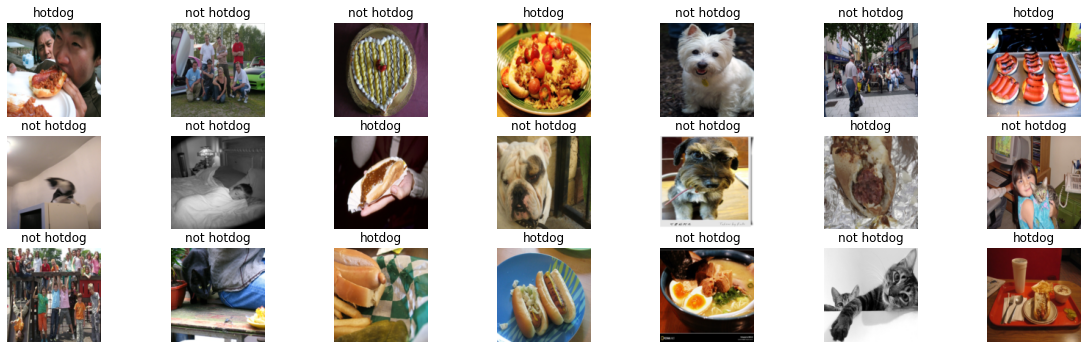

In [5]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')


Remember to save the state of your model AND optimizer regularly in case the Colab runtime times out.
You can save your model to your google drive, so you can get it from there in a new colab session. 

If you only save it in the colab notebook, there's no way to get it into a new session.

Now create a model and train it!


In [6]:
#We define the training as a function so we can easily re-use it.
def train(model, optimizer, num_epochs=10):
    def loss_fun(output, target):
        loss = nn.CrossEntropyLoss()
        return loss(output, target)
    out_dict = {'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}
    patience = 0
  
    for epoch in tqdm(range(num_epochs), unit='epoch'):        
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            #Compute the loss
            loss = loss_fun(output, target)
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            train_loss.append(loss.item())
            #Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().cpu().item()
        #Comput the test accuracy
        test_loss = []
        test_correct = 0
        model.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
            test_loss.append(loss_fun(output, target).cpu().item())
            predicted = output.argmax(1)
            test_correct += (target==predicted).sum().cpu().item()
        out_dict['train_acc'].append(train_correct/len(trainset))
        out_dict['test_acc'].append(test_correct/len(testset))
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['test_loss'].append(np.mean(test_loss))
        print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
              f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%")
        
        wandb.log({"train_acc": out_dict['train_acc'][-1],
                  "test_acc": out_dict['test_acc'][-1],
                  "train_loss": out_dict['train_loss'][-1],
                   "test_loss": out_dict['test_loss'][-1]})      
        
        if out_dict['test_loss'][-1] > min(out_dict['test_loss']):
            patience += 1 
        else: 
            patience = 0
            
        if patience == 7:
            print("EARLY STOPPED!")
            break 
       
    return out_dict

In [ ]:
class VGG_Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()       
        
        self.convolutional = nn.Sequential(
               nn.Conv2d(3, 32, 3, stride=1, padding=1),
               nn.BatchNorm2d(32),
               nn.ReLU(),
               nn.Conv2d(32, 32, 3, stride=1, padding=1),
               nn.BatchNorm2d(32),
               nn.ReLU(),
               nn.MaxPool2d(2, 2),
               nn.Dropout(p=0.2),
               nn.Conv2d(32, 64, 3, stride=1, padding=1),
               nn.BatchNorm2d(64),
               nn.ReLU(),
               nn.Conv2d(64, 64, 3, stride=1, padding=1),
               nn.BatchNorm2d(64),
               nn.ReLU(),
               nn.MaxPool2d(2, 2),
               nn.Dropout(p=0.2)
               )

        self.fully_connected = nn.Sequential(
                nn.Linear(32*32*64, 128),
                nn.ReLU(),
                nn.Dropout(p=0.2),
                nn.Linear(128, 2))
    def forward(self, x):
        x = self.convolutional(x)
        #reshape x so it becomes flat, except for the first dimension (which is the minibatch)
        x = x.view(x.size(0), -1)
        x = self.fully_connected(x)
        return x

In [7]:
model_SGD = VGG_Network()
model_ADAM = VGG_Network()

model_SGD.to(device)
model_ADAM.to(device)

#Initialize the optimizer
SGD_lr = 0.001
ADAM_lr = 0.000005
optimizer_SGD = torch.optim.SGD(model_SGD.parameters(), lr=SGD_lr)
optimizer_ADAM = torch.optim.Adam(model_ADAM.parameters(),lr=ADAM_lr)

num_epoch = 30

wandb: Currently logged in as: gizemggungor. Use `wandb login --relogin` to force relogin


  0%|          | 0/30 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.705	 test: 0.699	 Accuracy train: 54.2%	 test: 50.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.676	 test: 0.686	 Accuracy train: 59.0%	 test: 56.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.660	 test: 0.678	 Accuracy train: 64.2%	 test: 58.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.647	 test: 0.692	 Accuracy train: 67.2%	 test: 53.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.639	 test: 0.670	 Accuracy train: 66.9%	 test: 60.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.624	 test: 0.665	 Accuracy train: 71.0%	 test: 61.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.613	 test: 0.662	 Accuracy train: 73.0%	 test: 61.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.601	 test: 0.647	 Accuracy train: 74.5%	 test: 65.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.590	 test: 0.640	 Accuracy train: 76.2%	 test: 65.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.583	 test: 0.640	 Accuracy train: 75.9%	 test: 66.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.569	 test: 0.629	 Accuracy train: 77.8%	 test: 68.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.557	 test: 0.639	 Accuracy train: 78.8%	 test: 66.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.546	 test: 0.624	 Accuracy train: 78.5%	 test: 68.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.534	 test: 0.621	 Accuracy train: 79.6%	 test: 68.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.526	 test: 0.614	 Accuracy train: 80.2%	 test: 68.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.517	 test: 0.605	 Accuracy train: 79.4%	 test: 69.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.506	 test: 0.604	 Accuracy train: 79.8%	 test: 69.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.495	 test: 0.596	 Accuracy train: 81.1%	 test: 69.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.485	 test: 0.609	 Accuracy train: 81.0%	 test: 69.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.473	 test: 0.606	 Accuracy train: 82.2%	 test: 70.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.462	 test: 0.601	 Accuracy train: 82.9%	 test: 69.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.452	 test: 0.581	 Accuracy train: 82.8%	 test: 71.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.440	 test: 0.578	 Accuracy train: 83.8%	 test: 71.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.430	 test: 0.578	 Accuracy train: 84.6%	 test: 71.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.419	 test: 0.567	 Accuracy train: 85.2%	 test: 72.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.410	 test: 0.575	 Accuracy train: 86.2%	 test: 71.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.398	 test: 0.558	 Accuracy train: 86.9%	 test: 73.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.385	 test: 0.561	 Accuracy train: 86.9%	 test: 72.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.371	 test: 0.552	 Accuracy train: 87.9%	 test: 73.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.363	 test: 0.546	 Accuracy train: 88.5%	 test: 73.7%


test_acc,▁▃▃▂▄▄▄▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇█▇████
test_loss,█▇▇█▇▆▆▆▅▅▅▅▅▄▄▄▄▃▄▄▄▃▂▂▂▂▂▂▁▁
train_acc,▁▂▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇█████
train_loss,█▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁
test_acc,0.73738
test_loss,0.54596
train_acc,0.88471
train_loss,0.36269


  0%|          | 0/30 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.679	 test: 0.711	 Accuracy train: 56.0%	 test: 48.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.619	 test: 0.644	 Accuracy train: 68.9%	 test: 65.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.580	 test: 0.624	 Accuracy train: 73.6%	 test: 66.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.542	 test: 0.602	 Accuracy train: 76.9%	 test: 68.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.507	 test: 0.595	 Accuracy train: 79.3%	 test: 69.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.472	 test: 0.577	 Accuracy train: 81.1%	 test: 71.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.434	 test: 0.564	 Accuracy train: 83.8%	 test: 72.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.395	 test: 0.559	 Accuracy train: 86.4%	 test: 73.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.358	 test: 0.548	 Accuracy train: 89.2%	 test: 72.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.316	 test: 0.531	 Accuracy train: 90.4%	 test: 74.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.273	 test: 0.529	 Accuracy train: 92.9%	 test: 74.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.237	 test: 0.531	 Accuracy train: 94.8%	 test: 74.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.198	 test: 0.523	 Accuracy train: 95.9%	 test: 74.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.169	 test: 0.525	 Accuracy train: 97.0%	 test: 75.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.136	 test: 0.540	 Accuracy train: 98.3%	 test: 75.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.113	 test: 0.540	 Accuracy train: 99.0%	 test: 75.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.091	 test: 0.548	 Accuracy train: 99.5%	 test: 75.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.073	 test: 0.557	 Accuracy train: 99.7%	 test: 75.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.058	 test: 0.573	 Accuracy train: 100.0%	 test: 75.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.048	 test: 0.601	 Accuracy train: 99.8%	 test: 74.8%
EARLY STOPPED!


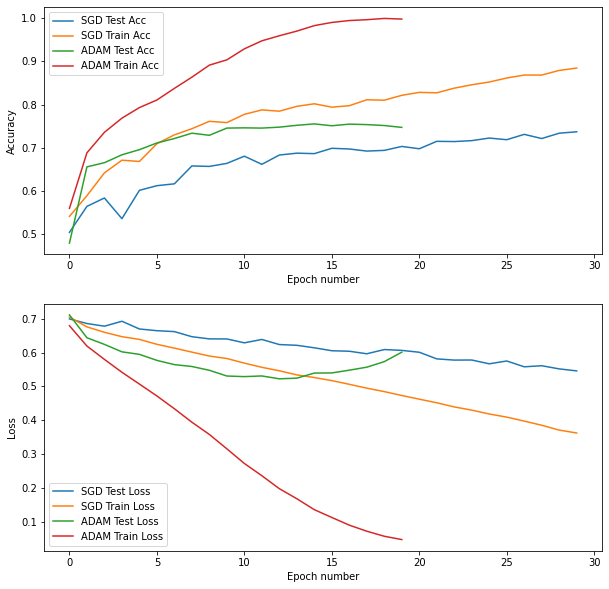

In [8]:
wandb.init(project="Hotdog", name="VGG_SGD", entity="gizemggungor")
wandb.config.update({
  "learning_rate": SGD_lr,
  "epochs": num_epoch,
  "optimizer" : "SGD",
  "predefined" : False,
  "data_augmentation" : True    
})

out_dict = train(model_SGD, optimizer_SGD, num_epoch)
fig, ax = plt.subplots(2,1,figsize=(10, 10))
ax[0].plot(out_dict["test_acc"], label='SGD Test Acc')
ax[0].plot(out_dict["train_acc"], label='SGD Train Acc')
ax[0].set_xlabel('Epoch number')
ax[0].set_ylabel('Accuracy')


ax[1].plot(out_dict["test_loss"], label='SGD Test Loss')
ax[1].plot(out_dict["train_loss"], label='SGD Train Loss')
ax[1].set_xlabel('Epoch number')
ax[1].set_ylabel('Loss')

wandb.init(project="Hotdog", name="VGG_ADAM", entity="gizemggungor")
wandb.config.update({
  "learning_rate": ADAM_lr,
  "epochs": num_epoch,
  "optimizer" : "ADAM",
  "predefined" : False,
  "data_augmentation" : True    
})
out_dict = train(model_ADAM, optimizer_ADAM, num_epoch)
ax[0].plot(out_dict["test_acc"], label='ADAM Test Acc')
ax[0].plot(out_dict["train_acc"], label='ADAM Train Acc')
ax[0].set_xlabel('Epoch number')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(out_dict["test_loss"], label='ADAM Test Loss')
ax[1].plot(out_dict["train_loss"], label='ADAM Train Loss')
ax[1].set_xlabel('Epoch number')
ax[1].set_ylabel('Loss')
ax[1].legend()